In [34]:
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
%run ../preprocessing/StimCodes.ipynb
%run ../Classification/ConcatEpochTrails.ipynb
%run ../PCA/Emmanuil-PCA.ipynb
%run ../preprocessing/Artifact_Removal/Extract_Describer_Events.ipynb
# %run ../preprocessing/frequency_bands.ipynb
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)
matplotlib.rcParams.update({'font.size': 15})
import numpy as np

import mne 

from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import ShuffleSplit

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout

import time

ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'Batch_ArtifactFilter_Epoch.ipynb.py'` not found.


# Exploring Word vs Non-word classification
* Non word vs word classification becomes more intriicate than just classifying audio vs visual.
    * We can say that there are word vs non-word classification tasks for both Auditory and Visual stimuli.

In [2]:
path = 'E:\stim_code_epochs'
epoch_files = os.listdir(path)
epoch_files

['20131216_1441_epo.fif',
 '20140205_1114_epo.fif',
 '20140205_1230_epo.fif',
 '20140206_1029_epo.fif',
 '20140206_1151_epo.fif',
 '20140207_1146_epo.fif',
 '20140207_1219_epo.fif',
 '20140217_1136_epo.fif',
 '20140217_1211_epo.fif',
 '20140219_1046_epo.fif',
 '20140219_1205_epo.fif',
 '20140220_1123_epo.fif',
 '20140225_1422_epo.fif',
 '20140227_1058_epo.fif',
 '20140227_1220_epo.fif',
 '20140227_1410_epo.fif',
 '20140304_1418_epo.fif',
 '20140306_1133_epo.fif',
 '20140306_1338_epo.fif',
 '20140313_1439_epo.fif',
 '20140313_1630_epo.fif',
 '20140314_1424_epo.fif',
 '20140314_1553_epo.fif',
 '20140318_1043_epo.fif',
 '20140318_1211_epo.fif',
 '20140319_1043_epo.fif',
 '20140319_1342_epo.fif',
 '20140320_1040_epo.fif',
 '20140320_1421_epo.fif',
 '20140324_1441_epo.fif',
 '20140324_1553_epo.fif',
 '20140325_1007_epo.fif',
 '20140327_1022_epo.fif',
 '20140331_1753_epo.fif',
 '20140402_1603_epo.fif',
 '20140402_1734_epo.fif',
 '20140404_1418_epo.fif',
 '20140404_1628_epo.fif',
 '20140410_1

## Visualization of Word vs Non-word EEG

In [3]:
epoch = mne.read_epochs(os.path.join(path,epoch_files[2]), preload = True)

Reading E:\stim_code_epochs\20140205_1230_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
978 matching events found
Applying baseline correction (mode: mean)
978 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [4]:
new_events = convert_epoch_events_to_stim_combinations(epoch_object=epoch)
epoch.events = new_events

In [5]:
#montage file
if 'Nasium' in epoch.ch_names:
    epoch.drop_channels(ch_names=['Nasium', 'LL4', 'L12', 'VEOG']);
montage = mne.channels.read_montage(kind = 'ANT_DukeWaveGuard_128_electrode_montages_updated_V4')
epoch.set_montage(montage);


In [6]:
epoch.events

array([[  7480,      0,    112],
       [  7730,      0,    112],
       [  7997,      0,    112],
       ...,
       [417664,      0,   1112],
       [417922,      0,   1112],
       [418189,      0,   1112]])

In [7]:
modality_lexicality_event_ids

{'AALL': 112,
 'AALN': 212,
 'AANL': 312,
 'AANN': 412,
 'AVLL': 512,
 'AVNN': 612,
 'VALL': 712,
 'VANN': 812,
 'VVLL': 912,
 'VVLN': 1012,
 'VVNL': 1112,
 'VVNN': 1212}

In [8]:
epoch.event_id = modality_lexicality_event_ids

In [9]:
def get_frequency_band(band, epoch_object):
    """
    Description:
        returns an epoch object with a filtered frequency band
    
    Variables: 
        band : 
            'Theta':(4,7),
            'Alpha':(8,12),
            'Beta':(13,25),
            'Gamma':(30,45)
        epoch_object: mne.epoch
    -----
    returns: epoch object
    
    """
    iter_freqs = {
        'Theta':(4,7),
        'Alpha':(8,12),
        'Beta':(13,25),
        'Gamma':(30,45)
    }
    copy_epoch = epoch_object.copy()
    copy_epoch.filter(l_freq= iter_freqs[band][0],
                    h_freq = iter_freqs[band][1])
    
    return copy_epoch


In [10]:
gamma_epoch = get_frequency_band('Gamma', epoch)

Setting up band-pass filter from 30 - 45 Hz
l_trans_bandwidth chosen to be 7.5 Hz
h_trans_bandwidth chosen to be 11.2 Hz
Filter length of 113 samples (0.441 sec) selected


In [11]:
mean_stats = get_mean_band(gamma_epoch)
mean_stats = mean_stats.swapaxes(1,2)

In [12]:
# Separate word and non-word events by audio and visual.
for event in epoch.events:
    first_digit = int(str(event[-1])[0])
    if first_digit%2 != 0:
        event[-1] = 100 #lexical
    else:
        event[-1] = 101 # non-lexical

In [13]:
# classification pipeline
start = time.time()
clf = make_pipeline(Vectorizer(),
                    StandardScaler(),
                    LogisticRegression(penalty='l1'))
end = time.time()
print("clf elapsed time: {0}".format(end - start))

start_master = time.time()
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

labels = epoch.events[:,-1]
preds = np.empty(len(mean_stats))
for train, test in cv.split(mean_stats, labels):
    start = time.time()
    clf.fit(mean_stats[train], labels[train])
    preds[test] = clf.predict(mean_stats[test])
    end = time.time()
    print("kfold elapsed time: {0}".format(end - start))
end = time.time()
print("classification elapsed time: {0}".format(end - start_master))


start = time.time()
target_names = ['Lexical', 'Non-Lexical']
report = classification_report(labels, preds, target_names=target_names)
print(report)
end = time.time()
print("reporting elapsed time: {0}".format(end - start))

clf elapsed time: 0.0


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 0.3481175899505615
kfold elapsed time: 0.18450641632080078


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 0.11968016624450684


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 0.22739267349243164


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 0.2433490753173828
classification elapsed time: 1.1250133514404297
              precision    recall  f1-score   support

     Lexical       0.65      0.66      0.65       558
 Non-Lexical       0.53      0.52      0.53       420

   micro avg       0.60      0.60      0.60       978
   macro avg       0.59      0.59      0.59       978
weighted avg       0.60      0.60      0.60       978

reporting elapsed time: 0.0029916763305664062


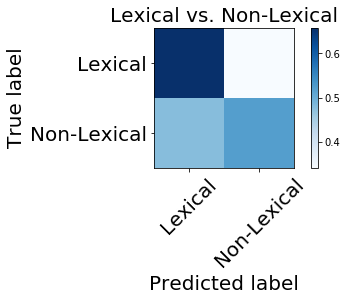

In [14]:
cm3 = confusion_matrix(labels, preds)
cm3_normalized = cm3.astype(float) / cm3.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm3_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Lexical vs. Non-Lexical', size = 20)
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, size = 20)
plt.yticks(tick_marks, target_names,size = 20)
tight_layout()
plt.ylabel('True label',size = 20)
plt.xlabel('Predicted label',size = 20)
plt.show()

In [16]:
#  X_train, X_test, y_train, y_test = train_test_split(gamma_epoch.get_data())

In [17]:
visual_channels = ['RC7','RD7','RE4','R12','R13','RR12','RR13',
                   'LC7','LD7',';LE4','L12','L13','LL12','LL13']
audio_channels = [x for x in epoch.ch_names if 'LD' in x or 'LC' in x or 'LA' in x
                  or 'RD' in x or 'RC' in x or 'RA' in x]

In [18]:
bad_channels = []
for ch in epoch.ch_names:
    if ch not in visual_channels and ch not in audio_channels:
        bad_channels.append(ch)
epoch.drop_channels(ch_names= bad_channels)

<EpochsFIF  |   978 events (all good), 0 - 1.94922 sec, baseline [0, 0], ~171.8 MB, data loaded,
 'AALL': 0
 'AALN': 0
 'AANL': 0
 'AANN': 0
 'AVLL': 0
 'AVNN': 0
 'VALL': 0
 'VANN': 0
 'VVLL': 0
 'VVLN': 0
 'VVNL': 0
 'VVNN': 0>

In [19]:
epoch.get_data().shape

(978, 46, 500)

In [20]:
gamma_epoch = get_frequency_band('Gamma', epoch)

Setting up band-pass filter from 30 - 45 Hz
l_trans_bandwidth chosen to be 7.5 Hz
h_trans_bandwidth chosen to be 11.2 Hz
Filter length of 113 samples (0.441 sec) selected


In [21]:
mean_stats = get_mean_band(gamma_epoch)
mean_stats = mean_stats.swapaxes(1,2)

In [22]:
# classification pipeline
start = time.time()
clf = make_pipeline(Vectorizer(),
                    StandardScaler(),
                    LogisticRegression(penalty='l1'))
end = time.time()
print("clf elapsed time: {0}".format(end - start))

start_master = time.time()
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

labels = epoch.events[:,-1]
preds = np.empty(len(mean_stats))
for train, test in cv.split(mean_stats, labels):
    start = time.time()
    clf.fit(mean_stats[train], labels[train])
    preds[test] = clf.predict(mean_stats[test])
    end = time.time()
    print("kfold elapsed time: {0}".format(end - start))
end = time.time()
print("classification elapsed time: {0}".format(end - start_master))


start = time.time()
target_names = ['Lexical', 'Non-Lexical']
report = classification_report(labels, preds, target_names=target_names)
print(report)
end = time.time()
print("reporting elapsed time: {0}".format(end - start))

clf elapsed time: 0.0
kfold elapsed time: 0.15358757972717285


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 0.06482648849487305
kfold elapsed time: 0.05485367774963379
kfold elapsed time: 0.07978606224060059


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 0.118682861328125
classification elapsed time: 0.47572779655456543
              precision    recall  f1-score   support

     Lexical       0.63      0.72      0.67       558
 Non-Lexical       0.54      0.44      0.48       420

   micro avg       0.60      0.60      0.60       978
   macro avg       0.58      0.58      0.58       978
weighted avg       0.59      0.60      0.59       978

reporting elapsed time: 0.0019948482513427734


In [23]:
# Lexical vs Non-Lexical needs more though...

In [24]:
epoch_1 = mne.read_epochs(os.path.join(path,epoch_files[2]), preload = True)
epoch_2 = mne.read_epochs(os.path.join(path,epoch_files[3]), preload = True)

Reading E:\stim_code_epochs\20140205_1230_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
978 matching events found
Applying baseline correction (mode: mean)
978 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Reading E:\stim_code_epochs\20140206_1029_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
949 matching events found
Applying baseline correction (mode: mean)
949 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [25]:
epoch = mne.concatenate_epochs([epoch_1, epoch_2])

1927 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 bad epochs dropped


In [26]:
#montage file
if 'Nasium' in epoch.ch_names:
    epoch.drop_channels(ch_names=['Nasium', 'LL4', 'L12', 'VEOG']);
montage = mne.channels.read_montage(kind = 'ANT_DukeWaveGuard_128_electrode_montages_updated_V4')
epoch.set_montage(montage);

In [27]:
#split by audio and visual 
## Visual - Lexical vs Non-Lexical

new_events = convert_epoch_events_to_stim_combinations(epoch)
epoch = epoch[:-1]
epoch.events = new_events

In [28]:
epoch.event_id = modality_lexicality_event_ids

In [29]:
modality_lexicality_event_ids

{'AALL': 112,
 'AALN': 212,
 'AANL': 312,
 'AANN': 412,
 'AVLL': 512,
 'AVNN': 612,
 'VALL': 712,
 'VANN': 812,
 'VVLL': 912,
 'VVLN': 1012,
 'VVNL': 1112,
 'VVNN': 1212}

In [30]:
#seprate labels into 4 differnt types.
# audio - lexical 
# audio - non-lexical
# visual- lexical
# visual- non-lexical

for event in epoch.events:
    first_digit = int(str(event[-1])[0])
    if event[-1] < 700  and first_digit %2 !=0:
        #Audio - lexical
        event[-1] = 100
    elif event[-1] < 700 and first_digit%2 == 0:
        #Audio - non-lexical
        event[-1] = 101
    elif event[-1] >700 and first_digit%2 !=0:
        #Visual - lexical
        event[-1] = 200
    else:
        # Visual non-lexical
        event[-1] = 201

In [31]:
# get gamma frequency
gamma_epoch = get_frequency_band('Gamma', epoch[:-1])

Setting up band-pass filter from 30 - 45 Hz
l_trans_bandwidth chosen to be 7.5 Hz
h_trans_bandwidth chosen to be 11.2 Hz
Filter length of 113 samples (0.441 sec) selected


In [32]:
gamma_epoch.get_data().shape

(1925, 125, 500)

In [33]:
mean_stats = get_mean_band(gamma_epoch)
mean_stats = mean_stats.swapaxes(1,2)

In [48]:
#extract each type of audio/visual - lexical/non-lexical event
audio_lexical = gamma_epoch[gamma_epoch.events[:,-1] == 100]
audio_non_lexical = gamma_epoch[gamma_epoch.events[:,-1] == 101]
visual_lexical = gamma_epoch[gamma_epoch.events[:,-1] == 200]
visual_non_lexical = gamma_epoch[gamma_epoch.events[:,-1] == 201]

In [86]:
print(audio_lexical.get_data().shape)
print(audio_non_lexical.get_data().shape)
print(visual_lexical.get_data().shape)
print(visual_non_lexical.get_data().shape)

(354, 125, 500)
(590, 125, 500)
(681, 125, 500)
(300, 125, 500)


In [91]:
# combine audio_lexical and audio-nonlexical
audio_lexical_data = audio_lexical.get_data()
audio_non_lexical_data = audio_non_lexical.get_data()[:354]
audio_lexicality_data = np.concatenate((audio_lexical_data, audio_non_lexical_data))
audio_lexicality_labels = np.concatenate((audio_lexical.events[:,-1], audio_non_lexical[:354].events[:,-1]))

In [105]:
mean_stats = get_mean_band(audio_lexicality_data)
mean_stats = mean_stats.swapaxes(1,2)

In [106]:
mean_stats.shape

(708, 125, 3)

In [124]:
audio_lexicality_data.shape

(708, 125, 500)

In [111]:
# classification pipeline
start = time.time()
clf = make_pipeline(Vectorizer(),
                    StandardScaler(),
                    LogisticRegression(penalty='l1'))
end = time.time()
print("clf elapsed time: {0}".format(end - start))

start_master = time.time()
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

labels = audio_lexicality_labels
preds = np.empty(len(mean_stats))
for train, test in cv.split(mean_stats, labels):
    start = time.time()
    clf.fit(mean_stats[train], labels[train])
    preds[test] = clf.predict(mean_stats[test])
    end = time.time()
    print("kfold elapsed time: {0}".format(end - start))
end = time.time()
print("classification elapsed time: {0}".format(end - start_master))


start = time.time()
target_names = ['Audio Lexical', 'Audio Non-Lexical']
report = classification_report(labels, preds, target_names=target_names)
print(report)
end = time.time()
print("reporting elapsed time: {0}".format(end - start))

clf elapsed time: 0.0009970664978027344
kfold elapsed time: 0.05884265899658203
kfold elapsed time: 0.06682085990905762
kfold elapsed time: 0.05684781074523926


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 0.05385637283325195
kfold elapsed time: 0.05784487724304199
classification elapsed time: 0.2962076663970947
                   precision    recall  f1-score   support

    Audio Lexical       0.86      0.82      0.84       354
Audio Non-Lexical       0.83      0.86      0.84       354

        micro avg       0.84      0.84      0.84       708
        macro avg       0.84      0.84      0.84       708
     weighted avg       0.84      0.84      0.84       708

reporting elapsed time: 0.0029926300048828125


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


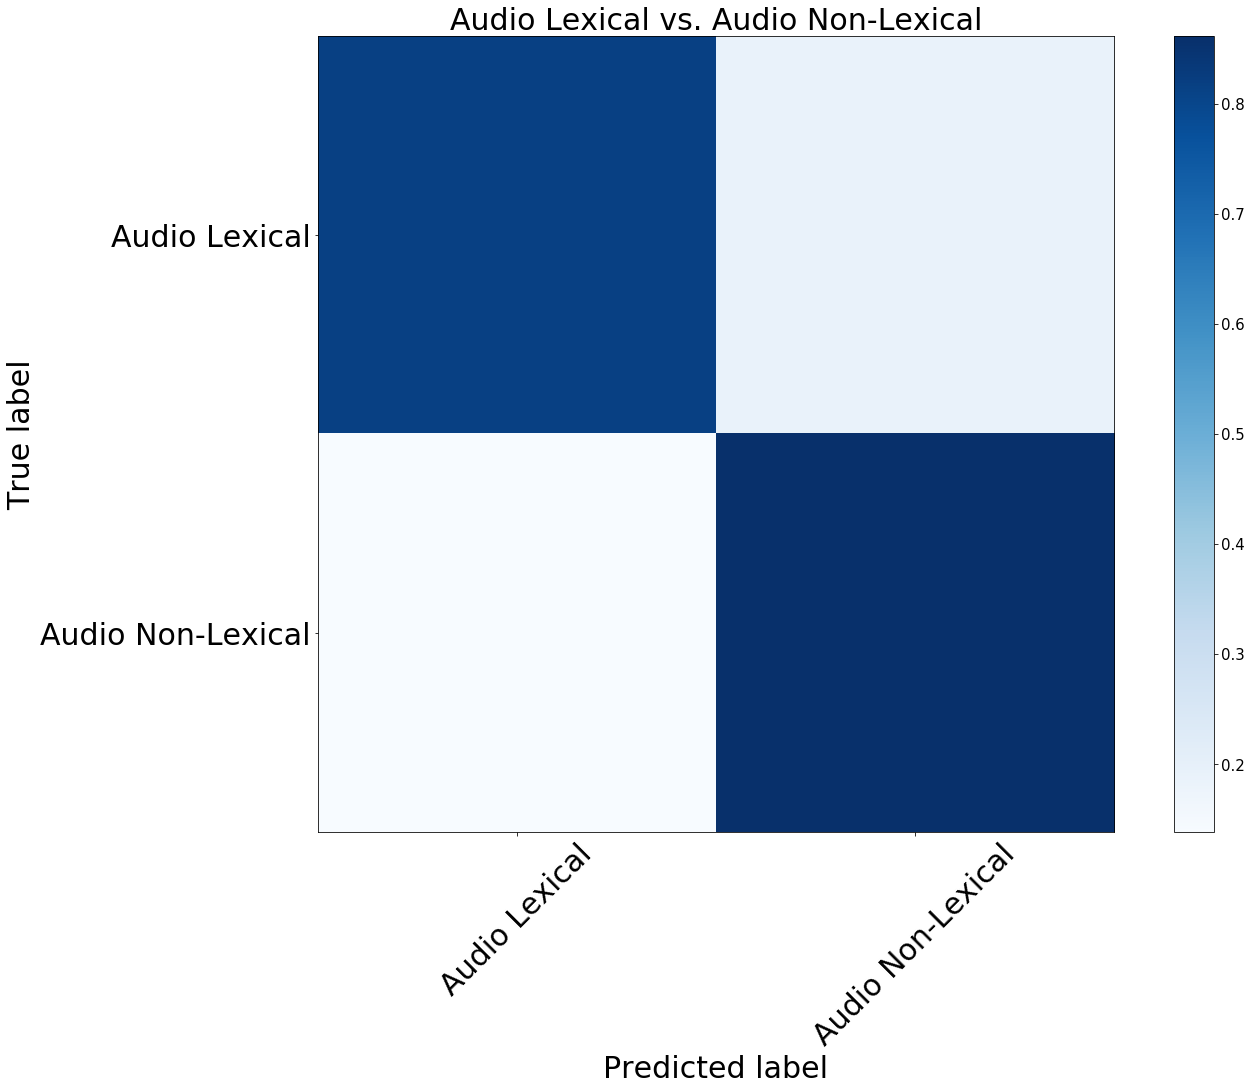

In [108]:
cm3 = confusion_matrix(labels, preds)
cm3_normalized = cm3.astype(float) / cm3.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm3_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Audio Lexical vs. Audio Non-Lexical', size = 30)
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, size = 30)
plt.yticks(tick_marks, target_names,size = 30)
tight_layout()
plt.ylabel('True label',size = 30)
plt.xlabel('Predicted label',size = 30)
plt.show()

In [95]:
gamma_epoch.get_data().shape

(1925, 125, 500)

In [125]:
visual_lexical_data = visual_lexical.get_data()[:300]
visual_non_lexical_data = visual_non_lexical.get_data()
visual_lexicality_data = np.concatenate((visual_lexical_data, visual_non_lexical_data))
visual_lexicality_labels = np.concatenate((visual_lexical[:300].events[:,-1], visual_non_lexical.events[:,-1]))

In [126]:
visual_lexicality_data.shape

(600, 125, 500)

In [127]:
visual_lexicality_mean_stats = (visual_lexicality_data)
visual_lexicality_mean_stats = visual_lexicality_mean_stats.swapaxes(1,2)

In [128]:
# classification pipeline
start = time.time()
clf = make_pipeline(Vectorizer(),
                    StandardScaler(),
                    LogisticRegression(penalty='l1'))
end = time.time()
print("clf elapsed time: {0}".format(end - start))

start_master = time.time()
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

labels = visual_lexicality_labels
preds = np.empty(len(visual_lexicality_mean_stats))
for train, test in cv.split(visual_lexicality_mean_stats, labels):
    start = time.time()
    clf.fit(visual_lexicality_mean_stats[train], labels[train])
    preds[test] = clf.predict(visual_lexicality_mean_stats[test])
    end = time.time()
    print("kfold elapsed time: {0}".format(end - start))
end = time.time()
print("classification elapsed time: {0}".format(end - start_master))


start = time.time()
target_names = ['Visual Lexical', 'Visual Non-Lexical']
report = classification_report(labels, preds, target_names=target_names)
print(report)
end = time.time()
print("reporting elapsed time: {0}".format(end - start))

clf elapsed time: 0.0


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 2.5491843223571777


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 2.5052990913391113


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 2.504304885864258


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 2.524249315261841


C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


kfold elapsed time: 2.5262441635131836
classification elapsed time: 12.61327075958252
                    precision    recall  f1-score   support

    Visual Lexical       0.55      0.60      0.57       300
Visual Non-Lexical       0.56      0.51      0.53       300

         micro avg       0.55      0.55      0.55       600
         macro avg       0.55      0.55      0.55       600
      weighted avg       0.55      0.55      0.55       600

reporting elapsed time: 0.002991914749145508


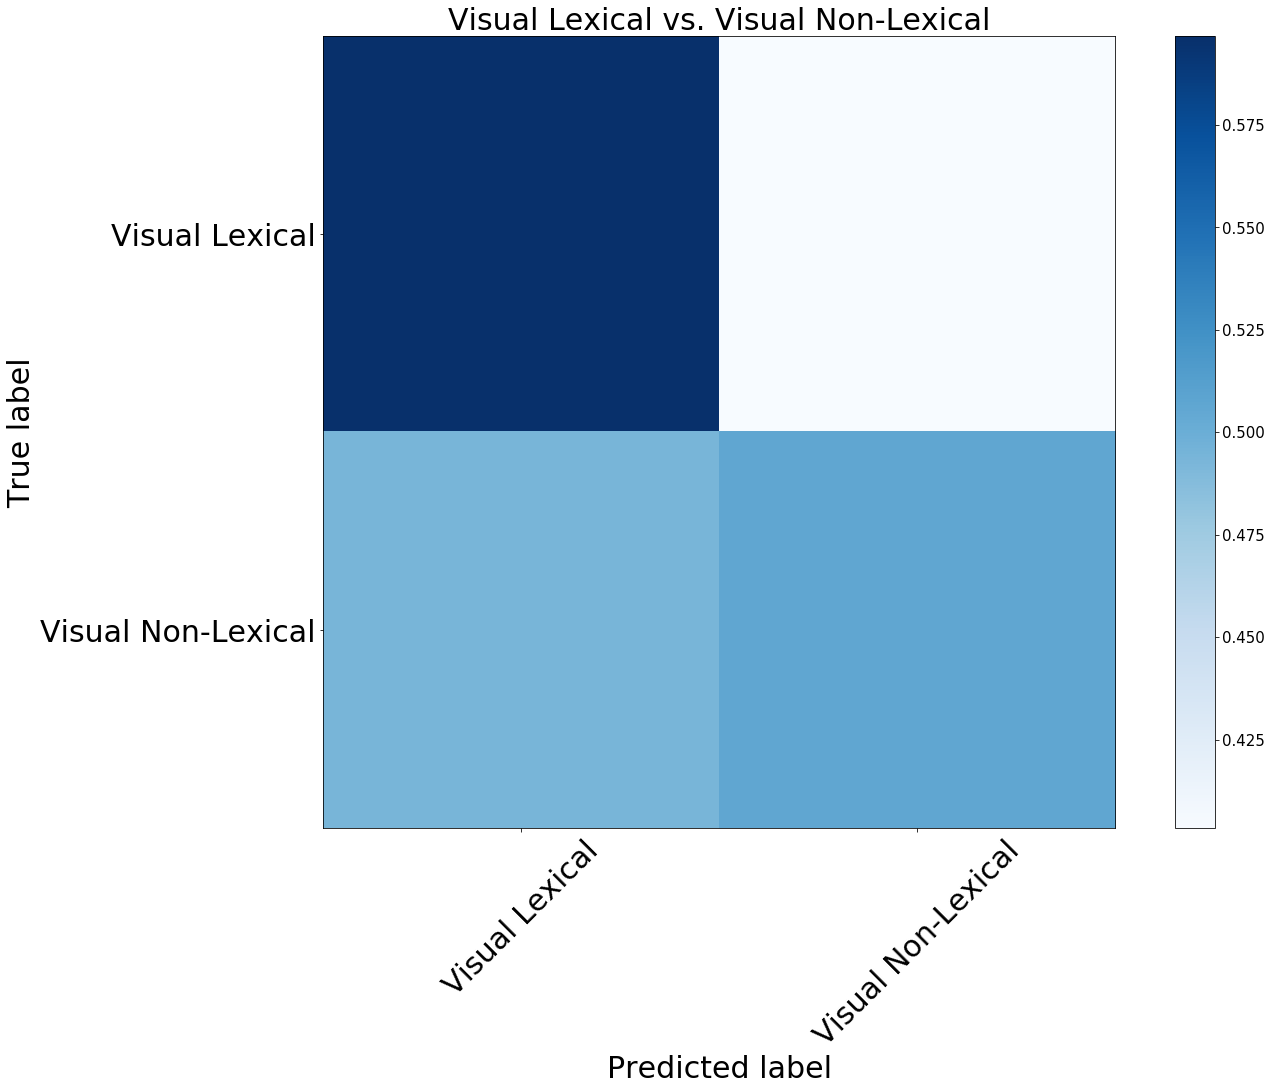

In [129]:
cm3 = confusion_matrix(labels, preds)
cm3_normalized = cm3.astype(float) / cm3.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm3_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Visual Lexical vs. Visual Non-Lexical', size = 30)
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, size = 30)
plt.yticks(tick_marks, target_names,size = 30)
tight_layout()
plt.ylabel('True label',size = 30)
plt.xlabel('Predicted label',size = 30)
plt.show()

In [119]:
visual_lexality_mean_stats.shape

(708, 3, 125)